In [15]:
import math
import copy
!pip install numpy
import numpy as np
import tensorflow as ts
import keras as kr
from keras.datasets import mnist
import pandas as pd
import import_ipynb



!pip install pillow
from PIL import Image, ImageColor
import IPython.display

from Position import Position
from Piece import Piece
from Board import Board
from Engine import Engine
from Game import Game
import SampleBot as sb

#this document was created to establish a working neural system for the AI


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


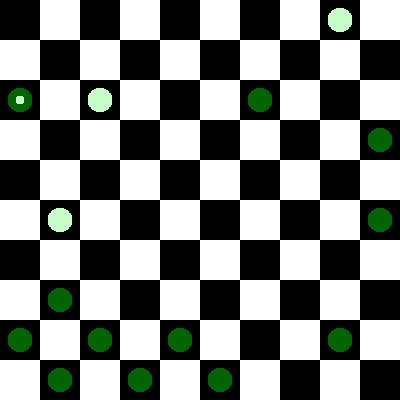

In [16]:
def hrevert(hashf):
    board = Board()
    unhash = board.empty_board()
    hashf = list(str(hashf))

        
    for i in range (100):
        if hashf[1+i] == '3':
            unhash.world[i//10][i%10] = unhash.newWhite(i//10, i%10, king=True)
        if hashf[1+i] == '2':
            unhash.world[i//10][i%10] = unhash.newWhite(i//10, i%10, king=False)
        if hashf[1+i] == '4':
            unhash.world[i//10][i%10] = unhash.newBlack(i//10, i%10, king=False)
        if hashf[1+i] == '5':
            unhash.world[i//10][i%10] = unhash.newBlack(i//10, i%10, king=True)
    
    
    if hashf[0] == 2:
        my_move = True
    else:
        my_move = False
        unhash = unhash.revert()

        
    
    return unhash, my_move

def htransform(hashf):
    t = []
    hashf = list(str(hashf))
    for i in range (10):
        t+=[[]]
        for j in range (10):
            if hashf[1+10*i+j] == '1':
                t[i] += [[5]]
            if hashf[1+10*i+j] == '3':
                t[i] += [[1]]
            if hashf[1+10*i+j] == '2':
                t[i] += [[4]]
            if hashf[1+10*i+j] == '4':
                t[i] += [[6]]
            if hashf[1+10*i+j] == '5':
                t[i] += [[9]]
    return t
    


file = open('archives.txt')
h = file.readlines()
h = h[1234].split(' ')[0]
file.close()
x = hrevert(h)[0]
x.show()

In [17]:
all_input = []
all_output = []
#prepping
file = open('archives.txt')
arr = file.readlines()
file.close()
for i in range (int(len(arr))):
    arr[i] = arr[i].split(' ')
    all_input += [htransform(arr[i][0])]#prepping the _in
    all_output += [float(arr[i][1])] #preppin the _out 
    
#I have 10k to split, 7-2-1?
train_in = all_input[:7000]
val_in = all_input[7001:9000]
test_in = all_input[9001:10000]
train_out = all_output[:7000]
val_out = all_output[7001:9000]
test_out = all_output[9001:10000]

In [18]:
#this creates a neural layer
lay = [
#minor features 
kr.layers.Conv2D(kernel_size = (3, 3), filters = 32, activation = 'relu', input_shape=[10, 10, 1]), #so the kernel size defines input as 3x3 chunk and filter adds 3 volume aka filters, right?
kr.layers.MaxPool2D(pool_size=2), #and how does pooling work on filters ?



kr.layers.Conv2D(kernel_size = (3, 3), filters = 64, activation = 'relu'),#same as above + how do stacked filters work? just use the former 32, mix them and form 64 new ones?
kr.layers.MaxPool2D(pool_size=2),
    
    
kr.layers.Flatten(), #combing every feature of a location into an integer evaluating an importance of that place - 
kr.layers.Dense(20, activation='sigmoid'),
kr.layers.Dense(10, activation='softmax')#softmax converts to perfect probability
#simple sectors merging and conclusion drawing - just like a normal full-dense but with more meaningful info

]
      
      
# units is the amount of neurons in a layer
neural_net = kr.Sequential(lay)

In [20]:
neural_net.compile(
    optimizer='adam', #hill climbing function
    loss=kr.losses.SparseCategoricalCrossentropy(from_logits = False), #estimated bias
    metrics=kr.metrics.MeanSquaredError(
    name='mean_squared_error', dtype=None
))
 #how we measure how the program is doing


In [21]:
tin = ts.convert_to_tensor(train_in)
tou = ts.convert_to_tensor(train_out)
vin = ts.convert_to_tensor(val_in)
vou = ts.convert_to_tensor(val_out)
tein = ts.convert_to_tensor(test_in)
teou = ts.convert_to_tensor(test_out)

In [22]:
callback1 = kr.callbacks.EarlyStopping(
monitor='val_mean_squared_error',
mode='auto',    
patience=15,
)
callback2 = kr.callbacks.ReduceLROnPlateau(monitor='val_mean_squared_error',
mode = 'auto',
factor=0.2,
patience=5, min_lr=0.001)




history = neural_net.fit(
train_in,
train_out,
validation_data=(val_in, val_out),
batch_size = 16, #ile sampli przed verification
epochs = 100,  #ile razy przelecicec przez caly dataset,
verbose = 1, #print logs about how it is going
callbacks = [callback1, callback2]
)

history = pd.DataFrame(history.history) #changing history to pandas database
history.loc[5:, ['mean_squared_error', 'val_mean_squared_error']].plot()


test_loss, test_acc = neural_net.evaluate(test_in, test_out, verbose=2)

Epoch 1/100


InvalidArgumentError:  Received a label value of -1 which is outside the valid range of [0, 10).  Label values: 1 0 -1 0 1 20 1 5 1 11 8 9 19 14 999 26
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\OEM\AppData\Local\Temp/ipykernel_15036/3278230175.py:14) ]] [Op:__inference_train_function_1601]

Function call stack:
train_function
